## Hotlap Analysis - 2022 vs. 2021

In 2022 F1 introduced new regulations completely overhauling the design of F1 cars. Over a single lap, what has changed? I'll analyze a lap from a Ferrari driver to see what we can determine.

In [47]:
#Import packages
import pandas as pd
import numpy as np
import fastf1 as ff1
#Enable the cache
ff1.Cache.enable_cache('C:/Users/jackh/OneDrive/Documents/Python Scripts/f1_cache') 

In [48]:
#Get the data
#Get data
quali_2021 = ff1.get_session(2021, 'Bahrain', 'Q')
quali_2022 = ff1.get_session(2022, 'Bahrain', 'Q')

#Get the laps
laps_21 = quali_2021.load_laps(with_telemetry=True)
laps_22 = quali_2022.load_laps(with_telemetry=True)

#Select all laps from Charles Leclerc in both 2021 & 2022
lec_2021 = laps_21.pick_driver('LEC')
lec_2022 = laps_22.pick_driver('LEC')

#Get their fastest data telemetry
fastest_2021 = lec_2021.pick_fastest().get_telemetry().add_distance()
fastest_2022 = lec_2022.pick_fastest().get_telemetry().add_distance()

#And add the driver variable
fastest_2021['Year'] = '2021'
fastest_2022['Year'] = '2022'


#Finally, merge both objects into a single dataframe
telemetry = fastest_2021.append(fastest_2022)

telemetry.head()



core           INFO 	Loading laps for Bahrain Grand Prix - Qualifying [v2.1.13]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['31', '4', '9', '6', '7', '18', '5', '33', '47', '44', '3', '22', '10', '99', '55', '77', '11', '16', '14', '63']
core           INFO 	Loading laps for Bahrain Grand Prix - Qualifying [v2.1.13]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api       

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,DRS,Source,RelativeDistance,Status,X,Y,Z,Distance,Year
2,2021-03-27 15:59:12.501,0 days 01:14:12.116000,,432.520833,0 days 00:00:00,10584,295,8,100,0,12,interpolation,0.000006,OnTrack,-382,1200,-155,0.000000,2021
3,2021-03-27 15:59:12.644,0 days 01:14:12.259000,,432.520833,0 days 00:00:00.143000,10604,296,8,100,0,12,pos,0.002186,OnTrack,-378,1318,-159,11.757778,2021
4,2021-03-27 15:59:12.675,0 days 01:14:12.290000,,432.520833,0 days 00:00:00.174000,10645,297,8,100,0,12,car,0.002660,OnTrack,-376,1343,-159,14.315278,2021
5,2021-03-27 15:59:12.864,0 days 01:14:12.479000,,432.520833,0 days 00:00:00.363000,10676,297,8,100,0,12,pos,0.005549,OnTrack,-369,1499,-159,29.907778,2021
6,2021-03-27 15:59:12.915,0 days 01:14:12.530000,33,432.520833,0 days 00:00:00.414000,10708,298,8,100,0,12,car,0.006331,OnTrack,-367,1541,-158,34.129444,2021


In [49]:
#Limit analysis to speed for each year and round each distance to the nearest 5 meters

speed = telemetry.pivot(index = 'Distance'
                    , columns = 'Year'
                    , values = 'Speed').sort_values('Distance').reset_index()

#speed = speed.sort_values('Distance')

In [50]:
#Are there enough values in each column?
speed.count()
#More datapoints for 2021 than 2022... but hopefully still sufficient


Year
Distance    1481
2021         785
2022         697
dtype: int64

In [55]:
#Round to the nearest 5 meters
def custom_round(x, base=5):
    return int(base * round(float(x)/base))

speed['distance_group'] = speed['Distance'].apply(lambda x: custom_round(x, base=5))

speed = speed.loc[:,speed.columns!='Distance']

In [63]:
#Interpolation of data
speed_filled = speed.fillna(method = 'ffill')

#Average speed by group
speed_filled = speed_filled.groupby('distance_group').mean().reset_index()

#Validate
speed_filled.count()

#Speed differential for each distance 'bucket'
speed_filled['speed_gap_22'] = speed_filled['2022'] - speed_filled['2021']
speed_filled['speed_gap_22_pct'] = speed_filled['2022'] / speed_filled['2021'] - 1

### Graphing the data

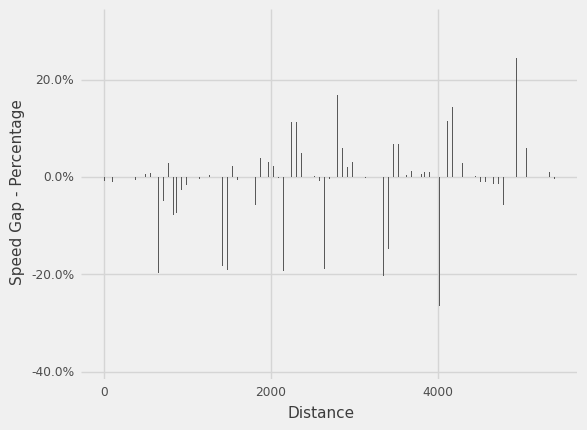

In [67]:
# Pct gap by segment
chart = speed_filled.copy()
chart['speed_gap_22_pct'] = chart['speed_gap_22_pct']*100

#Chart
from plotnine import ggplot, aes, geom_col, geom_line, theme_538, scale_fill_manual, labs, ggtitle, guides, scale_y_continuous, scale_color_manual, scale_fill_manual, coord_flip
from mizani.formatters import custom_format

a = (ggplot(chart, aes(x="distance_group", y = "speed_gap_22_pct"))
     + geom_col()
     + theme_538()
     + labs(x='Distance', y = 'Speed Gap - Percentage')
     + scale_y_continuous(labels=custom_format('{:.1f}%'))
)

print(a)

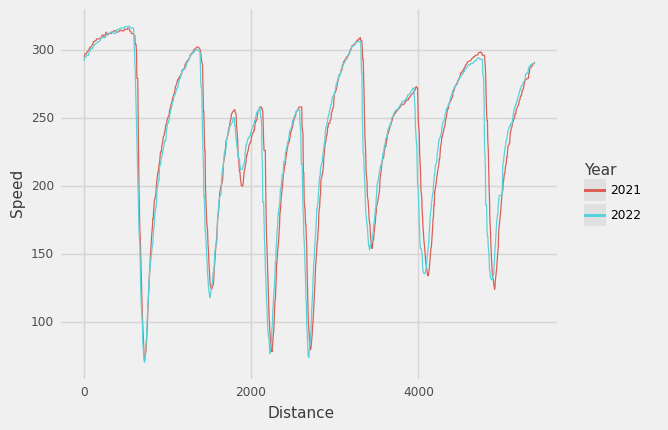

In [74]:
#Then unpivot data (for graphing)
chart = speed_filled[['distance_group', '2021', '2022']].melt(id_vars=['distance_group'], var_name = 'Year', value_name = 'Speed')

#Chart
from plotnine import ggplot, aes, geom_col, geom_line, theme_538, scale_fill_manual, labs, ggtitle, guides, scale_y_continuous, scale_color_manual, scale_fill_manual, coord_flip
from mizani.formatters import custom_format

a = (ggplot(chart, aes(x="distance_group", y = "Speed", color = "Year"))
     + geom_line()
     + theme_538()
     + labs(x='Distance', y = 'Speed')
)

print(a)

#### Creating Minisectors

Since we don't have telemetry data at exactly the same spots from session to session, one helpful way to standardize the results is to break the hot laps into 25 minisectors. I will do this below.

In [4]:
#Define number of minisectors
num_minisectors = 25

#Get max distance on the track
total_distance = total_distance = max(telemetry['Distance'])

#Generate equally-sized mini-sectors
minisector_length = total_distance/num_minisectors

#Now we can find the point at which each minisector starts
minisectors = [0]

for i in range(0, (num_minisectors-1)):
    minisectors.append(minisector_length * (i+1))

#And we can figure out where in each minisector the car was at the moment the data point was recorded
telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda dist: (
        int((dist // minisector_length) + 1)
    )
)

telemetry.head()